<center><h2>ALTeGraD 2023<br>Lab Session 3: Transfer learning for NLP</h2> 24 / 10 / 2023<br> Dr. G. Shang, H. Abdine<br><br>


<b>Student name:</b> Razafindralambo Raphaël

</center>

<br><br>
In this lab we will:
* Implement and pretrain a language model with transformer architecture.
* Use the pretrained model (transfer learning) to perform a sentiment analysis task which consists of classifying some books reviews into positive and negative ones.
* Compare the performance of the pretrained model to a model trained from scratch.
 <br>

<b>The deadline for this lab is October 31, 2023 11:59 PM.</b> More details about the submission and the architecture for this lab can be found in the handout PDF.

In [2]:
import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Model

Dimension of the output
• Pretraining task: size of vocabulary because we predict the next token so a distribution (probabilities) for the words
• Fine tuning: if binary classification (ex good or bad): size 2, if multi-class (ex: how many star this book review will have): size k. Number of classes.

"Shifted input": Input starts with "sos", so it's the input but shifted by 1 column to the left (to get rid of "sos").
Kind of impossible to have the same length for the phrase, as the input (because means 0 loss which is impossible)

Task 1: Use nn module from pytorch. We have an embedding layer, then positional encoding layer (just need to check parameters in the lab) then transformer layer (stack of layers, directly from pytorch because we have already self attention. self attention + mask).

Question 3: Tell about number of parameters in embedding, then for positional encoding, then for transformer layer. Don't need to include normalization parameter, just need layer parameters

Output transformer pour classification: 1 truc qui représente la séquence entière. Last word will represent the whole sequence, because to predict it we considered the whole sequence.
Last word = eos.


nn.TransformerLayer

• Un mécanisme d'attention multi-têtes, qui permet au modèle de se concentrer sur différentes parties de l'entrée pour chaque élément de la séquence.

• Une feedforward network, qui est une petite réseau de neurones entièrement connecté qui traite chaque position de la séquence indépendamment des autres.

In [3]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         '''
        self.model_type = "Transformer"
        self.encoder = nn.Embedding(ntoken, nhid) # fill me, nhid = the dim_embed
        self.pos_encoder = PositionalEncoding(nhid,dropout)
        #fill me, the PositionalEncoding class is implemented in the next cell

        encoder_layers = nn.TransformerEncoderLayer(d_model = nhid, nhead=nhead,dim_feedforward=nhid, dropout = dropout)
        #fill me we assume nhid = d_model = dim_feedforward

        self.transformer_encoder = nn.TransformerEncoder(encoder_layers,nlayers) #fill me
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.nhid)
        src = self.pos_encoder.forward(src)
        output = self.transformer_encoder(src,src_mask)
        return output


class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(nhid, nclasses) #fill me
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)
        return output

class Model(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken, nhead, nhid, nlayers, dropout) #fill me
        self.classifier = ClassificationHead(nhid,nclasses) #fill me

    def forward(self, src, src_mask):
        # base model
        x = self.base.forward(src,src_mask)#fill me
        # classifier model
        output = self.classifier.forward(x)#fill me
        return output

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

Let's verify if our model works, by applying one inference step

In [5]:
ntokens = 100 # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

print(out.shape) # is it the right shape?

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([1, 6, 100])


## Vocabulary and Tokenization

In [6]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
!head -5 dict.txt

--2023-10-31 20:16:45--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577587 (564K) [text/plain]
Saving to: ‘dict.txt’

dict.txt            100%[===================>] 564.05K  --.-KB/s    in 0.01s   

2023-10-31 20:16:45 (53.4 MB/s) - ‘dict.txt’ saved [577587/577587]

▁d 1
es 1
▁l 1
en 1
on 1


In [7]:
path_vocab = "dict.txt"
token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3} # the 4 first indices are reserved to special tokens
with open(path_vocab, "r") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        token2ind[word] = idx+4 #fill me

ind2token = {v: k for k, v in token2ind.items()} #fill me

print(ind2token[1111])

▁trop


### Data Loader


In [8]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        source_sequence = [token2ind['<sos>']] #fill me (constract the input sequence using token2ind, sequence and special tokens)
        for word in sequence:
          if word in token2ind:
            source_sequence.append(self.token2ind[word])
          else:
            source_sequence.append(self.token2ind["<oov>"])
        # <sos> A B C D

        #shift pour langage modelling
        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=512,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## The Training

In [9]:
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )

    losses = []
    for idx, data in enumerate(data_loader): #step 1
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask) #step 2


        if task == 'classification':
            #last vector only
            inds = []
            for i in range(batch_size):
                seq = input[:,i]
                if seq[-1] != 1:
                  #last vector
                  ind = output.shape[0]-1
                else:
                  #last non padding vector
                  ind = (seq == 1).nonzero(as_tuple=True)[0][0].item()-1
                inds.append(ind)
            inds = torch.tensor(inds).to(device)
            output = output.gather(0, inds.view(1, -1, 1).expand(-1, -1, output.size(2)))
        output = output.view(-1, output.shape[-1])
        target = data[1]#fill me
        target = target.to(device)

        #fill me step 3:  Compute the loss through back-propagation
        loss = criterion(output, target)#fill me, Cross entropy check next cells. Loss(output,target)

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient
        #fill me step 4: update the parameters of your model using sgd
        loss.backward() #calculate gradient
        optimizer.step() #update parameters


        total_loss += loss.item()
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [10]:
ntokens = len(token2ind)#fill me # the size of vocabulary
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

In [11]:
# optimization paramerters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [12]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = "pretraining_subset.txt"

--2023-10-31 20:21:29--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10146460 (9.7M) [text/plain]
Saving to: ‘pretraining_subset.txt’

pretraining_subset. 100%[===================>]   9.68M  --.-KB/s    in 0.02s   

2023-10-31 20:21:30 (401 MB/s) - ‘pretraining_subset.txt’ saved [10146460/10146460]



In [13]:
#pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        task="language_modeling", # fill me
        batch_size=16,
        log_interval=log_interval,
    )

| epoch   1 |   500/ 3125 steps | loss 7.31947 | ppl 1509.408
| epoch   1 |  1000/ 3125 steps | loss 6.51089 | ppl  672.423
| epoch   1 |  1500/ 3125 steps | loss 6.24587 | ppl  515.878
| epoch   1 |  2000/ 3125 steps | loss 6.06648 | ppl  431.162
| epoch   1 |  2500/ 3125 steps | loss 5.91220 | ppl  369.519
| epoch   1 |  3000/ 3125 steps | loss 5.81821 | ppl  336.370
| epoch   2 |   500/ 3125 steps | loss 5.53317 | ppl  252.945
| epoch   2 |  1000/ 3125 steps | loss 5.49552 | ppl  243.599
| epoch   2 |  1500/ 3125 steps | loss 5.46041 | ppl  235.193
| epoch   2 |  2000/ 3125 steps | loss 5.40917 | ppl  223.446
| epoch   2 |  2500/ 3125 steps | loss 5.38917 | ppl  219.021
| epoch   2 |  3000/ 3125 steps | loss 5.35233 | ppl  211.100


## Text Generation


In [48]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt

model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device)

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt')
#load state dict
model.load_state_dict(checkpoint['model_state_dict'])

--2023-10-31 21:00:11--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88093955 (84M) [application/octet-stream]
Saving to: ‘pretrained_model_4layers.pt.1’

pretrained_model_4l 100%[===================>]  84.01M   479MB/s    in 0.2s    

2023-10-31 21:00:11 (479 MB/s) - ‘pretrained_model_4layers.pt.1’ saved [88093955/88093955]



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [49]:
!pip install sentencepiece   # uncomment this if you are using google colab
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

--2023-10-31 21:00:18--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115362 (1.1M) [application/octet-stream]
Saving to: ‘sentencepiece.french.model.1’

sentencepiece.frenc 100%[===================>]   1.06M  --.-KB/s    in 0.009s  

2023-10-31 21:00:18 (124 MB/s) - ‘sentencepiece.french.model.1’ saved [1115362/1115362]

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [50]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces] # list of tokens
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    probs = torch.softmax(out,2)
    next_token_ind = torch.argmax(probs,2)[-1]
    return next_token_ind, out

def infer_next_tokens(sent, max_len=50):
    sentence_list = s.encode_as_pieces(sent)
    l = len(sentence_list)
    #indice 0 pour le premier argument du tuple
    next_ind = infer_next_token(sent)[0]

    next_token = ind2token[next_ind.item()]
    sentence_list.append(next_token)
    while (next_token != "<eos>" and len(sentence_list) < max_len):
      next_ind = infer_next_token(s.decode_pieces(sentence_list))[0]
      next_token = ind2token[next_ind.item()]
      sentence_list.append(next_token)
    if sentence_list[-1] == "<eos>": sentence_list = sentence_list[:-1]
    return s.decode_pieces(sentence_list[l:])


In [63]:
sent = "Bonjour les"
infer_next_tokens(sent)

'gens qui ont été très accueillants et sympathiques.'

### Supervised task

In [39]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = "train.review.spm"
path_labels_train = "train.label"

path_data_valid = "test.review.spm"
path_labels_valid = "test.label"

--2023-10-31 20:32:27--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1495960 (1.4M) [text/plain]
Saving to: ‘train.review.spm’

train.review.spm    100%[===================>]   1.43M  --.-KB/s    in 0.01s   

2023-10-31 20:32:27 (133 MB/s) - ‘train.review.spm’ saved [1495960/1495960]

--2023-10-31 20:32:27--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, 

In [40]:
# a function to evaluate the validation accuracy of the model.
def evaluate_accuracy(data_loader):
    model.eval()  # Mettre le modèle en mode évaluation
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for idx,batch in enumerate(data_loader):
            source = batch[0].to(device)
            targets = batch[1].to(device)
            src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
            predictions = model(source, src_mask)
            #On itère sur les phrases
            pred = []
            for i in range(source.shape[1]):
                seq = source[:,i]
                if seq[-1] != 1:
                  #prendre le dernier vecteur
                  res = predictions[-1,i,:]
                else:
                  #prendre le dernier vecteur non associé à <pad>
                  ind = (seq == 1).nonzero(as_tuple=True)[0][0].item()-1
                  res = predictions[ind,i,:]

                pred.append(torch.softmax(res,0).argmax())
            pred = torch.tensor(pred).to(device)
            """
            if idx == 0:
              print("Source: ", source.shape ,"[Taille phrase (apres padding), Nombre phrases]")
              print(source)
              print("Targets:", targets.shape, "[Nombre de phrases]")
              print(targets)
              print("Predictions:",predictions.shape, "[Taille phrase (apres padding), Nombre phrases, Nombre classes]")
              print(predictions[2,1,:].shape)
              print("Predictions classes:", pred.shape, "(1 prédiction par phrase)")

            """

            correct_predictions += torch.sum(pred == targets)
            total_predictions += targets.size(0)


    accuracy = correct_predictions / total_predictions
    return accuracy.item()

In [41]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [44]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)
    print()

=====Trainig FROM SCRATCH======
| epoch   1 |    50/  200 steps | loss 0.77911 | ppl    2.180
| epoch   1 |   100/  200 steps | loss 0.70698 | ppl    2.028
| epoch   1 |   150/  200 steps | loss 0.68884 | ppl    1.991
| epoch   2 |    50/  200 steps | loss 0.61924 | ppl    1.858
| epoch   2 |   100/  200 steps | loss 0.60597 | ppl    1.833
| epoch   2 |   150/  200 steps | loss 0.58539 | ppl    1.796
| epoch   3 |    50/  200 steps | loss 0.52686 | ppl    1.694
| epoch   3 |   100/  200 steps | loss 0.35856 | ppl    1.431
| epoch   3 |   150/  200 steps | loss 0.37556 | ppl    1.456
| epoch   4 |    50/  200 steps | loss 0.11225 | ppl    1.119
| epoch   4 |   100/  200 steps | loss 0.10045 | ppl    1.106
| epoch   4 |   150/  200 steps | loss 0.10850 | ppl    1.115
| epoch   5 |    50/  200 steps | loss 0.01963 | ppl    1.020
| epoch   5 |   100/  200 steps | loss 0.00998 | ppl    1.010
| epoch   5 |   150/  200 steps | loss 0.00653 | ppl    1.007
| epoch   6 |    50/  200 steps | loss

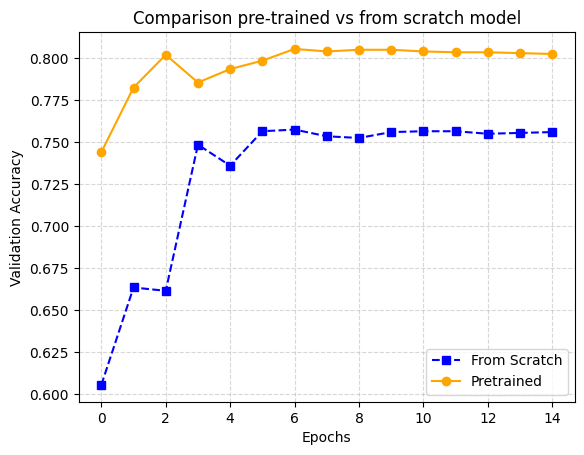

In [45]:
#Visualize the accuracy
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.plot(from_scratch_valid_acc, label='From Scratch', color='blue', linestyle='--', marker='s')
ax.plot(pretrained_valid_acc, label='Pretrained', color='orange', linestyle='-', marker='o')


ax.set_xlabel('Epochs')
ax.set_ylabel('Validation Accuracy')
ax.legend()
ax.set_title("Comparison pre-trained vs from scratch model")
ax.grid(True, linestyle='--', alpha=0.5)
plt.show()